# Introduction

### Group Member: Zhiyi Guo (zg2350), Yujie Wang (yw3442), Congcheng Yan (cy2550), Banruo Xie (bx2168)
The project below builds two collaborative filtering models, item-based method and model-based method, that used some open sourced packages and methods to implement our objective to recommend movies based on movie user score database. The most important metrics are generating similarity matrix for item-based method and rating matrix for model-based method in order to compare effectiveness in practical case by calculating their accurateness.

For business purpose, this project is primarily designed for internal company use. After comparing different methods' usefulness in database, discussion will be further made for final decision of letting which models will be put into real world application to recommend movies for users. The model with more accuracy and usefulness will be selected. Our business rule is to using recommendation to improve customer satisfaction, user engagement and increase the number of short-term users to long-term user. Therefore, the better recommendation model can help us increase users and improve revenue.

# Data Preprocessing

We are trying to optimize Pearson coefficient by trying to get better MSE and NDCG in our metrics. We sacrifice the movie genre, timeslot to simplify our model. As for our model, it will automatically prefer popular items since it have more raw data recorded. The database is randomly selected with around 2 million ratings and 0.4 million tag applications across 27 thousand movies. After rearranging the dataset to 3 dimensions for userId, movieId and rating, then we group by userID to use top 10 percent of user who have rate the movie most. Similarly, we use 10 percent of movieID that are rated most by users. The reason is that the detailed rating of user and movie can generate more accurate model below.


In [1]:
import pandas as pd
import numpy as np
import math
from random import sample
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import time
import warnings
warnings.filterwarnings('ignore')

In [2]:
'''import ratings data, drop the timestamp'''
origin_data=pd.read_csv('./ml-20m/ratings.csv')
origin_data=origin_data.drop(["timestamp"],axis=1)
origin_data.head()

,userId,movieId,rating
0,1,2,3.5
1,1,29,3.5
2,1,32,3.5
3,1,47,3.5
4,1,50,3.5


In [3]:
'''group by useraID, and then choose top 10 percent userid that give the most quantity of ratings'''
c_userId=origin_data.groupby(["userId"]).count()
c_userId.sort_values(by="rating", ascending=False)

k1=c_userId["rating"].quantile(0.9)
c_userId=c_userId[c_userId["rating"]>k1]

t1=c_userId.index.values

In [4]:
'''group by moveiID, then choose top 10 percent of movie that have most rating given by users'''
c_movieId=origin_data.groupby(["movieId"]).count()
c_movieId.sort_values(by="rating", ascending=False)

k2=c_movieId["rating"].quantile(0.9)
c_movieId=c_movieId[c_movieId["rating"]>k2]

t2=c_movieId.index.values

In [5]:
'''choose 10000 users and 1000 movies as sample'''
t1=sample(t1.tolist(),10000)
t2=sample(t2.tolist(),1000)

data=origin_data[origin_data['userId'].isin(t1)]
data=data[data['movieId'].isin(t2)]
data.head()

,userId,movieId,rating
962,11,19,3.5
966,11,110,4.0
968,11,150,5.0
971,11,160,4.0
973,11,170,5.0


In [6]:
'''change data format for future use'''
result=data.pivot_table('rating','movieId','userId')
result.head()

userId,11,24,54,58,91,104,116,131,132,134,...,138343,138382,138387,138397,138404,138406,138411,138437,138454,138472
movieId,,,,,,,,,,,,,,,,,,,,,
2,NaN,NaN,3.0,NaN,3.5,NaN,2.0,1.0,3.0,NaN,...,2.5,4.0,3.5,NaN,2.5,3.0,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,3.0,NaN,2.0,NaN,NaN,NaN,...,NaN,3.0,3.5,5.0,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,2.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,3.0,NaN,NaN,2.5,NaN,NaN,NaN,NaN,NaN,...,NaN,3.0,3.0,NaN,3.5,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,1.5,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Collaborative Filtering

## Neighborhood-based (item-based)

Algorithm:<br>
1.determine a set of peers for every user<br>
2.calculate the similarity of each user within the peer set, comparing users on items that they have both rated<br>
3.use prediction function to fill in a user's missing rating--weighted average mean-centered rating from the users in the peer set.

(1) $\mu_u=\frac{\sum_{k \in I_u} r_{uk}}{|I_u|}$ <br>
(2) $s_{uj}=r_{uj}-\mu_u$<br>
(3) $r_{uj}=\mu_u+\frac{\sum_{v \in P_u(j)} Sim(u,v)(r_{vj}-\mu_v)}{\sum_{v \in P_u(j)}|Sim(u,v)|}$

For the first step, to determine the nearest neighbor for user, we use Pearson's correlation coefficient to find user's peer set. Pearson's correlation is the covariance of the two variables divided by the product of their standard deviations.

In [7]:
'''
We use pearson coefficient to find similarity between all items.
Input: original dataframe
Output: similarity matrix of all item in original dataframe
'''
def update_pearson(df):
    val_arr=df.values.copy()
    corr=[]
    for i in range(0, len(val_arr)):
        valid=sorted(np.argwhere(~np.isnan(val_arr[i])).flatten())
        corr.append(valid)

    values=df.values.copy()
    arr=np.zeros((df.shape[0],df.shape[0]))
    for i in range(0, len(values)):
        for j in range(i, len(values)):
            row1=values[i]
            row2=values[j]
            valid1=corr[i]
            valid2=corr[j]
            common=list(set(valid1) & set(valid2))
            if len(common)<=2:
                arr[i,j]=0
                arr[j,i]=0
                continue
            row_1=row1[common]
            row_2=row2[common]
            pearson=pearsonr(row_1,row_2)[0]
            arr[i,j]=pearson
            arr[j,i]=pearson
            d=pd.DataFrame(arr)
    return d

In [8]:
'''
Predict ratings for each item and user in original dataframe.
Input: original dataframe, top k similar movies for each movie
Output: a dataframe with all predicted ratings
'''
def predict(df,k):
    mu=df.mean(axis=1).values
    d=update_pearson(df)
    d=d.where(d.apply(lambda x: x.isin(x.nlargest(k)),axis=0),0)
    p_sum=d.abs().sum(axis=1).values
    subtract=df.sub(df.mean(axis=1), axis=0)
    r=np.where(np.isnan(d.values),0,d.values).dot(np.where(np.isnan(subtract.values),0,subtract.values))
    cp=df.values.copy()
    
    for (i,j), values in np.ndenumerate(cp):
        values=r[i,j]/p_sum[i]+mu[i]
        cp[i][j]=values
        
    df_result=pd.DataFrame(cp)
    df_result.columns=list(df.columns)
    df_result.index=list(df.index)
    
    return(df_result)

In [9]:
'''predict matrix'''
start1=time.time()
df_result=predict(result,10)
end1=time.time()

In [10]:
'''running time'''
run1=(end1-start1)/60
print(run1)

4.877385902404785


In [11]:
'''show predicted matrix below'''
df_result.head()

,11,24,54,58,91,104,116,131,132,134,...,138343,138382,138387,138397,138404,138406,138411,138437,138454,138472
2,3.650201,3.523008,3.096786,3.181269,3.483095,2.865869,2.344753,1.432106,2.708789,3.054077,...,2.616706,4.324833,3.697641,3.294961,3.059299,3.090368,3.080415,3.187688,3.294961,2.865869
3,2.887435,2.611037,2.826133,2.887435,2.991444,2.887435,1.801330,2.611037,2.887435,2.887435,...,2.887435,3.098992,3.201770,4.232831,2.933682,2.887435,2.826133,2.887435,2.887435,2.887435
5,2.983060,2.723498,2.809197,2.801129,2.853593,2.665760,2.207179,2.523033,2.584133,2.766781,...,2.735592,2.757304,2.919253,3.158770,3.097063,2.880937,2.768739,2.725628,2.819821,2.859689
7,3.099870,3.035435,3.099870,3.099870,2.712841,3.099870,3.099870,3.099870,2.961400,3.099870,...,3.099870,3.035435,3.035435,3.099870,3.358029,3.099870,3.099870,3.099870,3.099870,3.099870
9,2.695276,2.552629,2.691245,2.603933,2.536863,2.448319,1.919593,2.469157,2.525822,2.477285,...,2.487839,2.689166,2.495774,2.772044,2.650885,2.508121,2.635882,2.436912,2.525822,2.525822


### Recommend

In [31]:
'''
Use predicted dataframe to recommend movies to a specific user
Input: predicted dataframe, how many movies recommend to a user, userid
Output: userid, movieid, predicted rating
'''
def recommend(df, k, userid):
    index=list(df.nlargest(k, userid).iloc[:,0].index)
    rating=list(df.nlargest(k, userid).iloc[:,0].values)
    rec=zip([userid]*k,index,rating)
    return list(rec)

In [20]:
recommend(df_result, 5, 54)

[(54, 3361, 3.719271035284994),
 (54, 1197, 4.0),
 (54, 1286, 3.4609756097560975),
 (54, 2391, 3.724432948666932),
 (54, 2890, 3.603629845395474)]

### Evaluation

We choose mse as our primary accuracy metric and ndcg as our secondary accuracy metric.

In [21]:
'''
Use cross validation to tune k (neighborhood size)
Input: cross validation fold, top k similar movies for each movie
Output: an evaluation list with mean mse and mean ndcg score
'''
def cross_validation(n,k):
    mse=[]
    ndcg=[]
    
    for i in range(n):
        X_train, X_test, y_train, y_test = train_test_split(data[['userId','movieId']], data.rating, test_size=0.2)
        X_train['rating']=y_train
        test = pd.concat([X_test,y_test ], axis=1)
        result_train = X_train.pivot_table('rating','movieId','userId')
        comp=predict(result_train, k)
        comp['id'] =list(result_train.index)
        comp=pd.melt(comp, id_vars=['id'])
        comp.rename(columns = {'id':'userId', 'variable':'movieId'}, inplace = True) 
        test['userId']=test['userId'].astype(int)
        test['movieId']=test['movieId'].astype(int)
        comp['movieId']=comp['movieId'].astype(int)
        comp['userId']=comp['userId'].astype(int)
        combine = pd.merge(comp, test, how='inner', on=['userId', 'movieId'])
        pred=combine.value
        true=combine.rating
        mse.append(mean_squared_error(pred, true))
        ndcg.append(ndcg_score(true.values, pred.values, k=10, gains="exponential"))
    
    evaluate=[]   
    evaluate.append(sum(mse)/len(mse))
    evaluate.append(sum(ndcg)/len(ndcg))
    
    return evaluate

In [22]:
'''
Use cross validation to tune hyperparameter k (neighborhood size)
Input: a list of k that we want to test
Output: a metric, each row stands for each k, the first element is mean mse, the second element is mean ndcg
'''
def tune_k(list_k):
    metric=[]
    for k in list_k:
        metric.append(cross_validation(2,k))
    return metric

In [23]:
'''
https://gist.github.com/mblondel/7337391
Use online reference code to compute ndcg score for the model
'''
def dcg_score(y_true, y_score, k=10, gains="exponential"):
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])

    if gains == "exponential":
        gains = 2 ** y_true - 1
    elif gains == "linear":
        gains = y_true
    else:
        raise ValueError("Invalid gains option.")

    discounts = np.log2(np.arange(len(y_true)) + 2)
    return np.sum(gains / discounts)

def ndcg_score(y_true, y_score, k=10, gains="exponential"):
    best = dcg_score(y_true, y_true, k, gains)
    actual = dcg_score(y_true, y_score, k, gains)
    return actual/best

In [ ]:
'''change hyper parameter k (neighborhood size)'''
list_k=[5,10,50,100]
metric1=tune_k(list_k)

In [74]:
metric1=pd.DataFrame(metric1, columns=['mse','ndcg'])
metric1['k']=list_k
metric1

,mse,ndcg,k
0,1.593205,0.404131,5
1,1.625202,0.351184,10
2,1.552028,0.261973,50
3,1.534230,0.413890,100


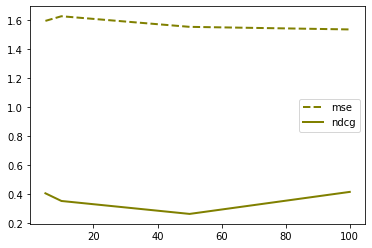

In [80]:
plt.plot('k', 'mse', data=metric, marker='', color='olive', linewidth=2, linestyle='dashed', label="mse")
plt.plot('k', 'ndcg', data=metric, marker='', color='olive', linewidth=2, label="ndcg")
plt.legend()
plt.show()

As the k increase from 5 to 100, mse is highest at 10, and then decrease, for ndcg, it decrease and is lowest at 50 and then increase. Base on the formula and definition of mse and ndcg, the best situation is the model have smaller mse and bigger ndcg,which is our objective. From the graph we can have that as k goes larger, the result is more closer to our objective. While the calculation and running time also increase as k increase, so we have to choose some trade-off, 'elbow method' is suggested.

In [32]:
'''
calculate coverage
choose some number of user to calculate the coverage percentage
if the recommend rating is greater then the threshold rating, then we see it as success
'''
def coverage(number_user, threshold, number):
    itr = 0
    count1 = []
    count2 = 0
    count3 = 0
    for i in number_user:
        count1.append(0)
        a = recommend(df_result, 5, i)
        for j in range(len(a)):
            b = a[j]
            if threshold <= b[2]:
                count1[itr] += 1
        for k in count1:
            if count1[itr] >= number:
                count2 += 1
        itr +=1
    for w in range(len(count1)):
        if count1[w] >= number:
            count3 += 1
    return count3/len(number_user)

In [33]:
id=list(df_result.columns)
coverage(id[0:100],4,3)

0.4

Q: What other design choices might you consider in order to have a more accurate or more useful model?\
A: For item based method, we can use Jaccard similarity. Jaccard similarity between two users is the number of items that they share in common, normalized by the total number of items between two users together. It is more appropriate for binary or unary ratings, where items are either in the set, or not. We can aslo calculate the euclidean distatnce between two points, where points is the user's data. It can be converted to similarity by subtracting it from zero.

### Larger dataset

In [6]:
'''data preprocessing for larger dataset'''
origin_data=pd.read_csv('./ml-20m/ratings.csv')
origin_data=origin_data.drop(["timestamp"],axis=1)
origin_data.head()

c_userId=origin_data.groupby(["userId"]).count()
c_userId.sort_values(by="rating", ascending=False)

k1=c_userId["rating"].quantile(0.85)
c_userId=c_userId[c_userId["rating"]>k1]

t1=c_userId.index.values

c_movieId=origin_data.groupby(["movieId"]).count()
c_movieId.sort_values(by="rating", ascending=False)

k2=c_movieId["rating"].quantile(0.85)
c_movieId=c_movieId[c_movieId["rating"]>k2]

t2=c_movieId.index.values

t1=sample(t1.tolist(),15000)
t2=sample(t2.tolist(),1500)

data2=origin_data[origin_data['userId'].isin(t1)]
data2=data2[data2['movieId'].isin(t2)]
data2.head()

,userId,movieId,rating
541,7,3,3.0
542,7,7,3.0
543,7,11,4.0
545,7,16,3.0
549,7,122,2.0


In [27]:
result2=data2.pivot_table('rating','movieId','userId')
result2.head()

userId,7,11,54,58,69,82,91,104,116,129,...,138406,138414,138437,138454,138456,138457,138472,138474,138483,138493
movieId,,,,,,,,,,,,,,,,,,,,,
2,NaN,NaN,3.0,NaN,NaN,NaN,3.5,NaN,2.0,3.0,...,3.0,NaN,NaN,NaN,3.0,NaN,NaN,4.0,3.0,4.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,3.0,4.5,4.0,NaN,NaN,NaN,1.5,NaN,...,NaN,NaN,4.0,4.0,NaN,NaN,NaN,5.0,NaN,NaN
7,3.0,NaN,NaN,NaN,NaN,NaN,2.5,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,NaN,2.5,4.0,NaN,3.0,NaN,4.0,NaN,2.0,NaN,...,3.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,3.0,NaN


In [30]:
'''predict matrix'''
start2=time.time()
df_result=predict(result2,10)
end2=time.time()

In [32]:
'''running time'''
run2=(end2-start2)/60
print(run2)

8.03255330324173


In [33]:
recommend(df_result, 5, 54)

[(54, 1200, 4.081000443927544),
 (54, 318, 4.407446539904147),
 (54, 3471, 3.8499206983891354),
 (54, 292, 3.1783216783216783),
 (54, 1197, 4.133459255261737)]

In [ ]:
'''change hyper parameter k (neighborhood size)'''
metric2=tune_k(list_k)

In [115]:
metric2=pd.DataFrame(metric2, columns=['mse','ndcg'])
metric2['k']=list_k
metric2

,mse,ndcg,k
0,1.665340,0.353869,5
1,1.609563,0.380762,10
2,1.445693,0.380926,50
3,1.504721,0.442990,100


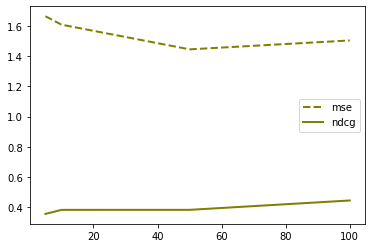

In [116]:
plt.plot('k', 'mse', data=metric2, marker='', color='olive', linewidth=2, linestyle='dashed', label="mse")
plt.plot('k', 'ndcg', data=metric2, marker='', color='olive', linewidth=2, label="ndcg")
plt.legend()
plt.show()

Compare two graphs, as the sample size increases, the overall accuracy increases for larger k (we notice that mse decreases a lot and ndcg increases a lot).

The distribution of accuracy is similar to smaller size data, but more accurate. We can notice that the second recommendation result has overall higher ratings than the first one.

The run-time increase as sample size increase. The smaller sample takes 4 min and larger sample takes 8 min. It is not linear relationship, the increase of running time is much bigger.

## Model-based (ALS)

In [12]:
from sklearn.model_selection import KFold
import pyspark
import sys
from pyspark.mllib.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.mllib.evaluation import RankingMetrics,RegressionMetrics
from pyspark.sql import SQLContext
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession

In [13]:
'''
setup Spark
'''
spark = SparkSession.builder.master("local").appName("appname").getOrCreate()

### Model & Evaluation

In [14]:
'''
Predict ratings for each item and user in original dataframe.
Input: original dataframe, degree, Iter, Param
Output: trained model, mse & other data for further use
'''

def getMse(ccc, degree, Iter, Param):
    time1 = time.time()
    d1 = spark.createDataFrame(ccc)
    (training, test) = d1.randomSplit([0.8, 0.2])
    model = ALS.train(training,degree,Iter,Param)
    testData = test.rdd.map(lambda p: (p.userId, p.movieId))
    predictions = model.predictAll(testData).map(lambda rating:((rating.user,rating.product), rating.rating))
    test1 = test.rdd.map(lambda p: ((p.userId, p.movieId),p.rating))
    ratingsAndPredictions=test1.join(predictions)
    predictionAndObservations = ratingsAndPredictions.map(lambda r:r[1]).map(lambda r:(r[1],r[0]))
    metrics = RegressionMetrics(predictionAndObservations)
    time2 = time.time()-time1
    rec = model.recommendProductsForUsers(10)
    rec1 = rec.map(lambda r:(r[0],[i.product for i in r[1]]))
    
    return (model,metrics.meanSquaredError,test1,rec1,time2)

In [15]:
'''
get ndcgAt(k) from ranking 
Input: an RDD of (predicted ranking, ground truth set) pairs 
Output: ndcgA(k)
'''
def getNdcg(rec1,test1,k):
    time1 =time.time()
    test2 = test1.map(lambda r:r[0])
    test3 = test2.groupByKey().map(lambda x : (x[0], list(x[1])))
    dtest = spark.createDataFrame(test3).withColumnRenamed("_1","userId").withColumnRenamed("_2","movieId")
    drec = spark.createDataFrame(rec1).withColumnRenamed("_1","userId").withColumnRenamed("_2","movie")
    left_join = drec.join(dtest, 'userId', 'left') # Could also use 'left_outer'
    t1 = lambda x:[] if  x is  None else x

    #ftest = left_join.rdd.map(lambda p: ([i.product for i in p.movie], t1(p.movieId)))
    ftest = left_join.rdd.map(lambda p: (p.movie,p.movieId))
    rmetrics = RankingMetrics(ftest)
    time2 = time.time()-time1

    return (rmetrics.ndcgAt(k),time2)

### Recommend

In [16]:
'''
Use predicted data to recommend movies to a specific user
Input: predicted data, userid, how many movies recommend to a user
Output: userid, movieid, predicted rating
'''
def recommend2(model,userId,num):
    try:
        return model.recommendProducts(userId,num)
    except:
        return "error userId maybe not in the model"

In [17]:
'''
Use cross validation to tune hyperparameter k (degree)
Input: a list of k that we want to test
Output: a metric, each row stands for each k, the first element is mean mse, the second element is mean ndcg
'''
def tune(ccc,n,list_k):
    time3 = time.time()
    metric=[]
    
    for k in list_k:
        mselist = []
        ndcglist = []
        for i in range(n):
            (model, mse, test1, rec1, time1) = getMse(ccc,k,10,0.01)
            mselist.append(mse)
            print(mselist)
            (ndcg,time2) = getNdcg(rec1,test1,10)
            ndcglist.append(ndcg)
            print(ndcglist)
        metric.append([sum(mselist)/len(mselist),sum(ndcglist)/len(ndcglist)])
    return (metric,time.time()-time3)

In [15]:
'''change hyper parameter k (degree)'''
klist = [2,4,6,8]
result = tune(data.reset_index(drop = True),1,klist)
result

[0.6518671727512199]
[0.11787361331787358]
[0.6127336807896789]
[0.13042337674009863]
[0.5914914522727006]
[0.13211341283435032]
[0.5815677202630529]
[0.1295291336028196]


([[0.6518671727512199, 0.11787361331787358],
  [0.6127336807896789, 0.13042337674009863],
  [0.5914914522727006, 0.13211341283435032],
  [0.5815677202630529, 0.1295291336028196]],
 829.2484786510468)

In [16]:
'''
collect the mse and ndcg
'''
metric=result[0]
metric=pd.DataFrame(metric, columns=['mse','ndcg'])
metric['k']=klist
metric

,mse,ndcg,k
0,0.651867,0.117874,2
1,0.612734,0.130423,4
2,0.591491,0.132113,6
3,0.581568,0.129529,8


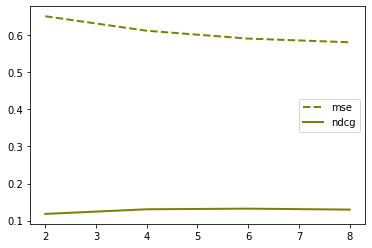

In [17]:
plt.plot('k', 'mse', data=metric, marker='', color='olive', linewidth=2, linestyle='dashed', label="mse")
plt.plot('k', 'ndcg', data=metric, marker='', color='olive', linewidth=2, label="ndcg")
plt.legend()
plt.show()

In [19]:
'''
running time for prediction
'''
runningtime1 = getMse(data.reset_index(drop = True),6,10,0.01)[-1]
runningtime1

74.8125512599945

In [18]:
'''
calculate coverage
choose some number of user to calculate the coverage percentage
if the recommend rating is greater then the threshold rating, then we see it as success
'''
def coverage2(number_user, threshold, number):
    itr = 0
    count1 = []
    count2 = 0
    count3 = 0
    for i in number_user:
        count1.append(0)
        a = recommend2(model, i, 5)
        for j in range(len(a)):
            b = a[j]
            if threshold <= b.rating:
                count1[itr] += 1
        for k in count1:
            if count1[itr] >= number:
                count2 += 1
        itr +=1
    for w in range(len(count1)):
        if count1[w] >= number:
            count3 += 1
    return count3/len(number_user)

In [19]:
result3 = getMse(data.reset_index(drop = True),6,10,0.01)
(model,mse,test1,rec1,time2) = result3

In [20]:
id=list(df_result.columns)
coverage2(id[0:100],4,3)

0.86

### Larger dataset

In [20]:
klist = [2,4,6,8]
result = tune(data2.reset_index(drop = True),1,klist)
result

[0.6524669850643859]
[0.09421622568857552]
[0.622872546040172]
[0.09946724030710721]
[0.608502544546211]
[0.09247036995166348]
[0.598535184409295]
[0.09744825139711778]


([[0.6524669850643859, 0.09421622568857552],
  [0.622872546040172, 0.09946724030710721],
  [0.608502544546211, 0.09247036995166348],
  [0.598535184409295, 0.09744825139711778]],
 991.1522214412689)

In [21]:
'''
collect the mse and ndcg
'''
metric=result[0]
metric=pd.DataFrame(metric, columns=['mse','ndcg'])
metric['k']=klist
metric

,mse,ndcg,k
0,0.652467,0.094216,2
1,0.622873,0.099467,4
2,0.608503,0.092470,6
3,0.598535,0.097448,8


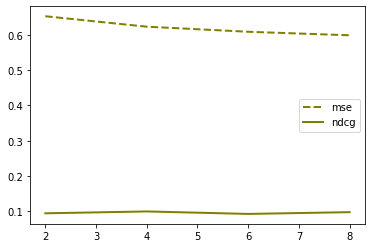

In [22]:
plt.plot('k', 'mse', data=metric, marker='', color='olive', linewidth=2, linestyle='dashed', label="mse")
plt.plot('k', 'ndcg', data=metric, marker='', color='olive', linewidth=2, label="ndcg")
plt.legend()
plt.show()

In [24]:
'''
running time for prediction
'''
runningtime2 = getMse(data.reset_index(drop = True),8,10,0.01)[-1]
runningtime2

88.39221334457397

### More detail info in write_up.pdf 